# Build your own Experiment

#### imports

In [2]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import re
import time
from tqdm.auto import tqdm

import torch
import piq
import lpips
from skimage.metrics import structural_similarity as ssim

from config import EXPERIMENTAL_DATA_PATH, SAVE_PATH, VIDEOS_PATH


c:\Users\Marie\Documents\info m2 local\Quality of Experience\projet\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pre treatment of raw data from experiment

#### Merge every participant's csv

In [36]:
csv_files = glob.glob(os.path.join(EXPERIMENTAL_DATA_PATH, "*.csv"))
print(f"Found {len(csv_files)} files:\n{csv_files}")

all_data = []
for file in csv_files:
    df = pd.read_csv(file)
    all_data.append(df)

df_combined = pd.concat(all_data, ignore_index=True)

df = df_combined.pivot_table(
    index=['reference', 'condition'],
    columns='participant',
    values='rating',
    aggfunc='first'
).reset_index()

df.columns = ['video', 'condition'] + [f'rating_{col}' for col in df.columns[2:]]

print(f"\nFinal dataframe: {df.shape}")
print(df.head(10))

Found 14 files:
['data\\christopher_01_samviq.csv', 'data\\cla_01_samviq.csv', 'data\\corgi_01_samviq.csv', 'data\\Elliot_01_samviq.csv', 'data\\emerik_01_samviq.csv', 'data\\Enzo_01_samviq.csv', 'data\\gabin_01_samviq.csv', 'data\\HU_01_samviq.csv', 'data\\LEI_01_samviq.csv', 'data\\lou-anne_01_samviq.csv', 'data\\malo_01_samviq.csv', 'data\\maria_01_samviq.csv', 'data\\VEDRAN_01_samviq.csv', 'data\\ZEKAI_01_samviq.csv']

Final dataframe: (36, 17)
                 video condition  rating_Elliot  rating_Enzo  rating_HU  \
0  Center_Book_arrival    Fehn_c             86           92         75   
1  Center_Book_arrival    Fehn_i             88           88         77   
2  Center_Book_arrival     Holes             35           30         55   
3  Center_Book_arrival  ICIP_TMM             80           58         85   
4  Center_Book_arrival      ICME             87           48         66   
5  Center_Book_arrival  Original            100          100         98   
6      Center_Lovebird

#### Video path

In [37]:
def find_video(originals, ref, condition, data):
    to_cam_position, video_label = ref.split('_', 1)
    if condition == 'Original':
        filtre = (
            (data['Algo'] == condition) &
            (data['from_cam_position'] == originals) &
            (data['Video'].str.contains(video_label, case=False, na=False))
        )
    else :
        filtre = (
            (data['Algo'] == condition) &
            (data['from_cam_position'] == originals) &
            (data['to_cam_position'] == to_cam_position) &
            (data['Video'].str.contains(video_label, case=False, na=False))
        )
    candidates = data.loc[filtre, 'Video_path']
    if candidates.empty:
        print(f"No video found for {originals}, {ref}, {condition}")
    return candidates.iloc[0] if not candidates.empty else None

In [38]:
# Map camera number to position by source
cam_position_map = {
    "Book_arrival": {8: "Left", 9: "Center", 10: "Right"},
    "Lovebird": {6: "Left", 7: "Center", 8: "Right"},
    "Newspaper": {4: "Left", 5: "Center", 6: "Right"},
}

sources = {
    "Book_arrival": "Book_arrival",
    "Lovebird": "Lovebird1",
    "Newspaper": "Newspaper",
}

original_videos_dict = {}

data = pd.read_csv(SAVE_PATH + "df_videos_processed.csv")

for index, row in data.iterrows():
    if row["Algo"] == "Original":
        video_path = row["Video_path"]
        video_id = row["Video_ID"]

        # "Book_arrival_8.avi" -> 8
        match = re.search(r'_(\d+)\.avi$', video_path)
        if match:
            cam_number = int(match.group(1))
            key = (video_id, cam_number)
            original_videos_dict[key] = video_path

print(f"{len(original_videos_dict)} original videos found")

9 original videos found


In [39]:
df['Video_path'] = pd.Series(dtype=str)
df['Source'] = pd.Series(dtype=str)
not_found = 0

for index, row in df.iterrows():
    
    # find video path
    originals = 'Left'
    video_name = row['video']
    condition = row['condition']
    video_path = find_video(originals, video_name, condition, data)
    df.at[index, 'Video_path'] = video_path if video_path else None

    # find name of source video
    to_cam_position, video_label = video_name.split('_', 1)
    source_name = sources.get(video_label, None)
    df.at[index, 'Source'] = source_name

    # find path of original and predicted videos
    match = re.search(r'(\d+)_to_(\d+)', video_path)
    if match:
        from_cam = int(match.group(1))
        to_cam = int(match.group(2))
        df.at[index, "from_cam"] = from_cam
        df.at[index, "to_cam"] = to_cam

        key_from = (source_name, from_cam)
        df.at[index, "from_video_path"] = original_videos_dict.get(key_from, None)
        if df.at[index, "from_video_path"] is None:
            print(f"Original video not found for {key_from} (from_cam)")
            not_found += 1

        key_to = (source_name, to_cam)
        df.at[index, "ref_video_path"] = original_videos_dict.get(key_to, None)
        if df.at[index, "ref_video_path"] is None:
            print(f"Original video not found for {key_to} (to_cam)")
            not_found += 1
    else:
        df.at[index, "from_cam"] = None
        df.at[index, "to_cam"] = None
        df.at[index, "from_video_path"] = None
        df.at[index, "ref_video_path"] = None
        not_found += 1


df.drop(columns=['from_cam', 'to_cam'], inplace=True)
df = df[["Video_path", "from_video_path", "ref_video_path", "video", "Source", "condition"] + [col for col in df.columns if col not in ['Video_path', "from_video_path", "ref_video_path", "video", "Source", "condition"]]]
df.head(10)


,Video_path,from_video_path,ref_video_path,video,Source,condition,rating_Elliot,rating_Enzo,rating_HU,rating_LEI,...,rating_ZEKAI,rating_christopher,rating_cla,rating_corgi,rating_emerik,rating_gabin,rating_lou-anne,rating_malo,rating_maria,rating_yasmina
0,Book_arrival_A1_8_to_9.avi,Book_arrival_cam_08.avi,Book_arrival_cam_09.avi,Center_Book_arrival,Book_arrival,Fehn_c,86,92,75,64,...,70,22,59,80,74,85,83,90,89,81
1,Book_arrival_A2_8_to_9.avi,Book_arrival_cam_08.avi,Book_arrival_cam_09.avi,Center_Book_arrival,Book_arrival,Fehn_i,88,88,77,78,...,90,35,66,88,72,84,31,65,76,78
2,Book_arrival_A7_8_to_9.avi,Book_arrival_cam_08.avi,Book_arrival_cam_09.avi,Center_Book_arrival,Book_arrival,Holes,35,30,55,61,...,47,79,0,32,26,41,13,44,12,23
3,Book_arrival_A6_8_to_9.avi,Book_arrival_cam_08.avi,Book_arrival_cam_09.avi,Center_Book_arrival,Book_arrival,ICIP_TMM,80,58,85,81,...,84,48,51,70,90,60,56,81,55,53
4,Book_arrival_A5_8_to_9.avi,Book_arrival_cam_08.avi,Book_arrival_cam_09.avi,Center_Book_arrival,Book_arrival,ICME,87,48,66,89,...,56,65,42,57,61,73,19,58,44,53
5,Book_arrival_cam_08.avi,None,None,Center_Book_arrival,Book_arrival,Original,100,100,98,87,...,97,5,100,100,100,100,96,100,100,90
6,Lovebird1_A1_6_to_7.avi,Lovebird_cam_06.avi,Lovebird_cam_07.avi,Center_Lovebird,Lovebird1,Fehn_c,90,75,97,61,...,84,26,77,89,78,77,61,75,73,63
7,Lovebird1_A2_6_to_7.avi,Lovebird_cam_06.avi,Lovebird_cam_07.avi,Center_Lovebird,Lovebird1,Fehn_i,90,74,92,69,...,82,46,91,71,75,94,50,60,82,72
8,Lovebird1_A7_6_to_7.avi,Lovebird_cam_06.avi,Lovebird_cam_07.avi,Center_Lovebird,Lovebird1,Holes,72,25,68,76,...,51,76,0,30,35,30,22,35,24,29
9,Lovebird1_A6_6_to_7.avi,Lovebird_cam_06.avi,Lovebird_cam_07.avi,Center_Lovebird,Lovebird1,ICIP_TMM,79,33,86,77,...,74,64,36,43,62,47,24,50,40,47


#### MOS, DMOS, CI

In [40]:
# MOS (Mean Opinion Score)
rating_cols = [col for col in df.columns if col.startswith("rating_")]
df["MOS"] = df[rating_cols].mean(axis=1)

# DMOS (Differential Mean Opinion Score)
reference_mos = df[df["condition"] == "Original"].groupby("video")["MOS"].mean()
df = df.join(reference_mos, on="video", rsuffix="_ref")
df["DMOS"] = df["MOS_ref"] - df["MOS"] + 20 ##############################TODO à ajuster

# Confidence Interval 95%
df["STD"] = df[rating_cols].std(axis=1)
nb_participants = len(rating_cols)
df["CI_95"] = 1.96 * df["STD"] / np.sqrt(nb_participants)

df.drop(columns=["MOS_ref", "STD"], inplace=True)
df.head(10)


,Video_path,from_video_path,ref_video_path,video,Source,condition,rating_Elliot,rating_Enzo,rating_HU,rating_LEI,...,rating_corgi,rating_emerik,rating_gabin,rating_lou-anne,rating_malo,rating_maria,rating_yasmina,MOS,DMOS,CI_95
0,Book_arrival_A1_8_to_9.avi,Book_arrival_cam_08.avi,Book_arrival_cam_09.avi,Center_Book_arrival,Book_arrival,Fehn_c,86,92,75,64,...,80,74,85,83,90,89,81,76.200000,35.333333,9.143733
1,Book_arrival_A2_8_to_9.avi,Book_arrival_cam_08.avi,Book_arrival_cam_09.avi,Center_Book_arrival,Book_arrival,Fehn_i,88,88,77,78,...,88,72,84,31,65,76,78,73.533333,38.000000,9.246522
2,Book_arrival_A7_8_to_9.avi,Book_arrival_cam_08.avi,Book_arrival_cam_09.avi,Center_Book_arrival,Book_arrival,Holes,35,30,55,61,...,32,26,41,13,44,12,23,35.466667,76.066667,10.271858
3,Book_arrival_A6_8_to_9.avi,Book_arrival_cam_08.avi,Book_arrival_cam_09.avi,Center_Book_arrival,Book_arrival,ICIP_TMM,80,58,85,81,...,70,90,60,56,81,55,53,66.733333,44.800000,7.702211
4,Book_arrival_A5_8_to_9.avi,Book_arrival_cam_08.avi,Book_arrival_cam_09.avi,Center_Book_arrival,Book_arrival,ICME,87,48,66,89,...,57,61,73,19,58,44,53,59.533333,52.000000,9.078815
5,Book_arrival_cam_08.avi,None,None,Center_Book_arrival,Book_arrival,Original,100,100,98,87,...,100,100,100,96,100,100,90,91.533333,20.000000,12.283262
6,Lovebird1_A1_6_to_7.avi,Lovebird_cam_06.avi,Lovebird_cam_07.avi,Center_Lovebird,Lovebird1,Fehn_c,90,75,97,61,...,89,78,77,61,75,73,63,74.466667,34.933333,8.760933
7,Lovebird1_A2_6_to_7.avi,Lovebird_cam_06.avi,Lovebird_cam_07.avi,Center_Lovebird,Lovebird1,Fehn_i,90,74,92,69,...,71,75,94,50,60,82,72,76.066667,33.333333,7.756646
8,Lovebird1_A7_6_to_7.avi,Lovebird_cam_06.avi,Lovebird_cam_07.avi,Center_Lovebird,Lovebird1,Holes,72,25,68,76,...,30,35,30,22,35,24,29,40.400000,69.000000,11.590467
9,Lovebird1_A6_6_to_7.avi,Lovebird_cam_06.avi,Lovebird_cam_07.avi,Center_Lovebird,Lovebird1,ICIP_TMM,79,33,86,77,...,43,62,47,24,50,40,47,52.466667,56.933333,10.160841


In [41]:
output_file = os.path.join(SAVE_PATH, "experimental_results.csv")
df.to_csv(output_file, index=False)
print(f"\nDataframe sauvegardé dans: {output_file}")


Dataframe sauvegardé dans: results/experimental_results.csv


## Statistical analysis of MOS and CI

#### MOS and CI visualization

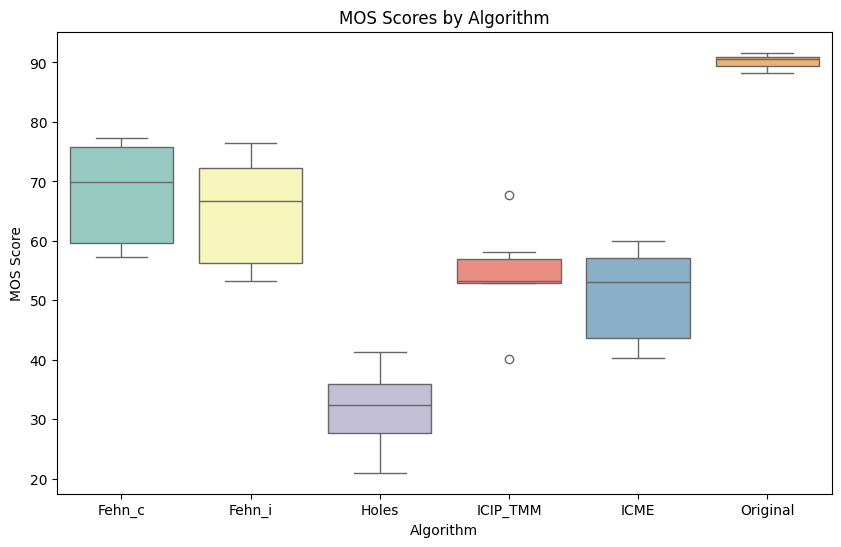

In [42]:
plt.figure(figsize=(10,6))
sns.boxplot(x="condition", y="MOS", data=df, hue="condition", palette="Set3", legend=False)
plt.title("MOS Scores by Algorithm")
plt.xlabel("Algorithm")
plt.ylabel("MOS Score")
plt.show()

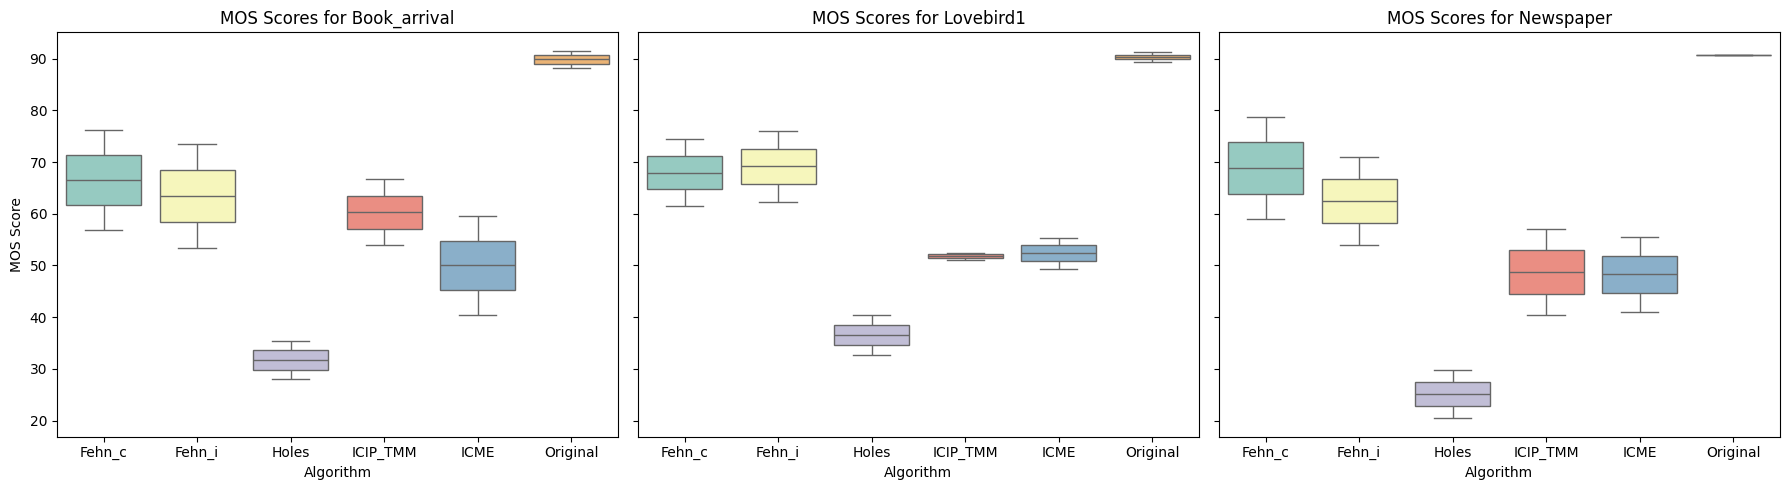

In [36]:
video_ids = df["Source"].unique()
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
for i, video_id in enumerate(video_ids):
    ax = axes[i]
    subset = df[df["Source"] == video_id]
    sns.boxplot(x="condition", y="MOS", data=subset, hue="condition", palette="Set3", ax=ax, legend=False)
    ax.set_title(f"MOS Scores for {video_id}")
    ax.set_xlabel("Algorithm")
    if i == 0:
        ax.set_ylabel("MOS Score")
    else:
        ax.set_ylabel("")
plt.tight_layout()
plt.show()

In [44]:
# Display MOS and CI from dataframe
print("Algorithm\t\tMean MOS ± CI")
print("-" * 50)
for algo in sorted(df['condition'].unique()):
    subset = df[df['condition'] == algo]
    mean_mos = subset['MOS'].mean()
    mean_ci = subset['CI_95'].mean()
    print(f"{algo:15s}\t{mean_mos:.3f} ± {mean_ci:.3f}  [{mean_mos-mean_ci:.3f}, {mean_mos+mean_ci:.3f}]")

Algorithm		Mean MOS ± CI
--------------------------------------------------
Fehn_c         	67.767 ± 9.125  [58.642, 76.892]
Fehn_i         	65.033 ± 9.219  [55.814, 74.252]
Holes          	31.133 ± 11.966  [19.167, 43.100]
ICIP_TMM       	53.622 ± 9.430  [44.192, 63.052]
ICME           	50.222 ± 9.766  [40.456, 59.988]
Original       	90.311 ± 12.905  [77.406, 103.216]


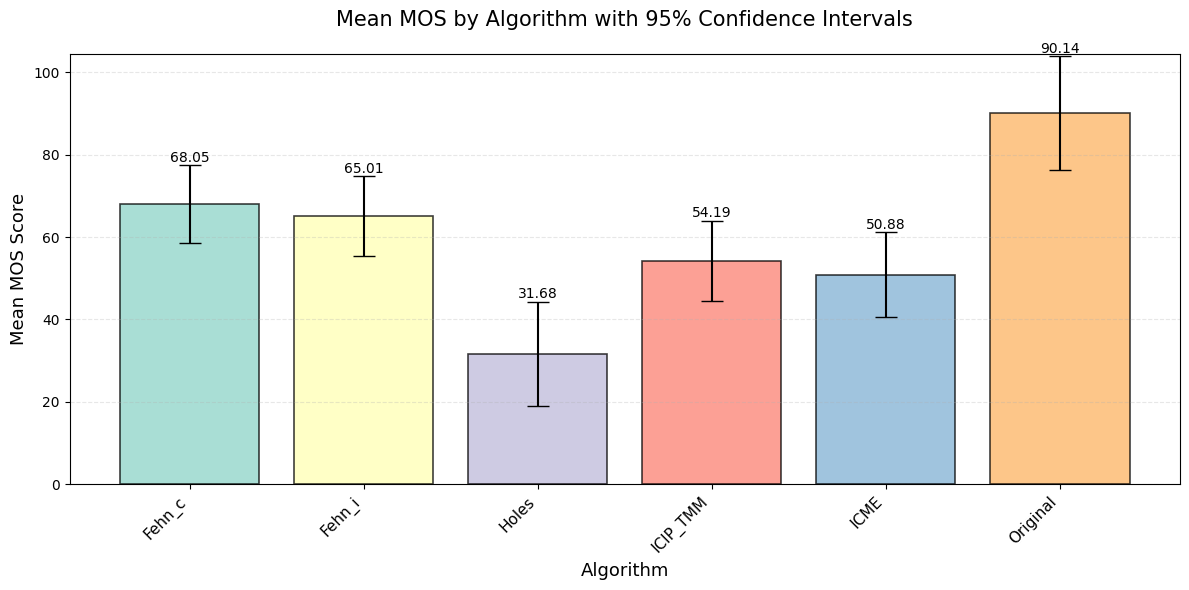

Non-overlapping CIs suggest statistically significant differences


In [45]:
# Visualization of Mean MOS with CI from dataframe
fig, ax = plt.subplots(figsize=(12, 6))

# Get means and CIs from dataframe
algos = sorted(df['condition'].unique())
means = []
cis = []

for algo in algos:
    subset = df[df['condition'] == algo]
    means.append(subset['MOS'].mean())
    cis.append(subset['CI_95'].mean())

# Create bar plot with error bars
x_pos = np.arange(len(algos))
bars = ax.bar(x_pos, means, yerr=cis, capsize=8, alpha=0.75, 
               color=sns.color_palette("Set3", len(algos)), 
               edgecolor='black', linewidth=1.2)

# Add value labels on bars
for i, (m, c) in enumerate(zip(means, cis)):
    ax.text(i, m + c + 0.05, f'{m:.2f}', ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Algorithm', fontsize=13)
ax.set_ylabel('Mean MOS Score', fontsize=13)
ax.set_title('Mean MOS by Algorithm with 95% Confidence Intervals', fontsize=15, pad=20)
ax.set_xticks(x_pos)
ax.set_xticklabels(algos, rotation=45, ha='right', fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(means) + max(cis) + 0.5)

plt.tight_layout()
plt.show()


print("Non-overlapping CIs suggest statistically significant differences")

#### Anova

In [46]:
# Statistical comparison: ANOVA test to check if there are significant differences between algorithms
from scipy.stats import f_oneway

# Prepare data for ANOVA
algo_groups = [group['MOS'].values for name, group in df.groupby('condition')]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*algo_groups)

print(f"One-Way ANOVA Results:")
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("\nConclusion: There are statistically significant differences between algorithms (p < 0.05)")
else:
    print("\nConclusion: No statistically significant differences between algorithms (p >= 0.05)")

One-Way ANOVA Results:
F-statistic: 35.5990
P-value: 9.636302255174144e-12

Conclusion: There are statistically significant differences between algorithms (p < 0.05)


In [47]:
#test de Dunnett
from statsmodels.stats.multicomp import pairwise_tukeyhsd
dunnett = pairwise_tukeyhsd(endog=df['MOS'], groups=df['condition'], alpha=0.05)
print(dunnett)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1   group2  meandiff p-adj   lower    upper   reject
----------------------------------------------------------
  Fehn_c   Fehn_i  -2.7333 0.9906 -16.7003  11.2336  False
  Fehn_c    Holes -36.6333    0.0 -50.6003 -22.6664   True
  Fehn_c ICIP_TMM -14.1444 0.0458 -28.1114  -0.1775   True
  Fehn_c     ICME -17.5444 0.0075 -31.5114  -3.5775   True
  Fehn_c Original  22.5444 0.0004   8.5775  36.5114   True
  Fehn_i    Holes    -33.9    0.0 -47.8669 -19.9331   True
  Fehn_i ICIP_TMM -11.4111 0.1607  -25.378   2.5558  False
  Fehn_i     ICME -14.8111 0.0327  -28.778  -0.8442   True
  Fehn_i Original  25.2778 0.0001  11.3108  39.2447   True
   Holes ICIP_TMM  22.4889 0.0004    8.522  36.4558   True
   Holes     ICME  19.0889 0.0031    5.122  33.0558   True
   Holes Original  59.1778    0.0  45.2108  73.1447   True
ICIP_TMM     ICME     -3.4 0.9751 -17.3669  10.5669  False
ICIP_TMM Original  36.6889    0.0   22.722  50.6558   Tr

In [38]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

mc = MultiComparison(df['MOS'], df['condition'])

result = mc.tukeyhsd()

filtered_results = result.summary().data[1:] 
filtered_results = [row for row in filtered_results if 'Original' in row[0] or 'Original' in row[1]]
for rows in filtered_results:
    print(rows)

['Fehn_c', 'Original', np.float64(22.5444), np.float64(0.0004), np.float64(8.5775), np.float64(36.5114), np.True_]
['Fehn_i', 'Original', np.float64(25.2778), np.float64(0.0001), np.float64(11.3108), np.float64(39.2447), np.True_]
['Holes', 'Original', np.float64(59.1778), np.float64(0.0), np.float64(45.2108), np.float64(73.1447), np.True_]
['ICIP_TMM', 'Original', np.float64(36.6889), np.float64(0.0), np.float64(22.722), np.float64(50.6558), np.True_]
['ICME', 'Original', np.float64(40.0889), np.float64(0.0), np.float64(26.122), np.float64(54.0558), np.True_]


In [39]:
print("=" * 70)
print("SUMMARY: Comparison of Each Algorithm vs. Original (Control)")
print("=" * 70)
print(f"{'Algorithm':<15} {'Mean Diff':<17} {'95% CI':<12} {'p-value':<6} {'Significant?'}")
print("-" * 70)

for row in filtered_results:
    group1, group2, meandiff, pval, lower, upper, reject = row
    if 'Original' in [group1, group2]:
        other_group = group1 if group2 == 'Original' else group2
        meandiff_adj = meandiff if group1 == 'Original' else -meandiff
        lower_adj = lower if group1 == 'Original' else -lower
        upper_adj = upper if group1 == 'Original' else -upper
        
        ci_str = f"[{lower_adj:6.3f}, {upper_adj:6.3f}]"
        sig_str = "YES" if reject else "NO"
        
        print(f"{other_group:<15} {meandiff_adj:>10.4f}  {ci_str:<20} {pval:>6}  {sig_str}")

SUMMARY: Comparison of Each Algorithm vs. Original (Control)
Algorithm       Mean Diff         95% CI       p-value Significant?
----------------------------------------------------------------------
Fehn_c            -22.5444  [-8.578, -36.511]    0.0004  YES
Fehn_i            -25.2778  [-11.311, -39.245]   0.0001  YES
Holes             -59.1778  [-45.211, -73.145]      0.0  YES
ICIP_TMM          -36.6889  [-22.722, -50.656]      0.0  YES
ICME              -40.0889  [-26.122, -54.056]      0.0  YES


## SI/TI

#### Def & computation

In [50]:
def calculate_SI(frame):
    """
    Calculate Spatial Information (SI) for a frame.
    SI measures the spatial complexity/detail in the frame.
    
    SI = std(Sobel(frame))
    Higher SI = more spatial detail/edges
    """
    # Convert to grayscale if needed
    if len(frame.shape) == 3:
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    else:
        gray = frame
    
    # Apply Sobel operator to detect edges
    sobel_x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=3)
    sobel_y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=3)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # SI is the standard deviation of the Sobel filtered frame
    si = np.std(sobel)
    return si

def calculate_TI(frame1, frame2):
    """
    Calculate Temporal Information (TI) between two consecutive frames.
    TI measures the amount of motion/change between frames.
    
    TI = std(frame_diff)
    Higher TI = more motion/temporal change
    """
    # Convert to grayscale if needed
    if len(frame1.shape) == 3:
        gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
    else:
        gray1 = frame1
        gray2 = frame2
    
    # Calculate frame difference
    diff = gray2.astype(np.float64) - gray1.astype(np.float64)
    
    # TI is the standard deviation of the frame difference
    ti = np.std(diff)
    return ti

def analyze_video_SI_TI(video_path, max_frames=300):
    """
    Analyze a video and return its SI and TI values.
    
    Parameters:
    - video_path: path to video file
    - max_frames: maximum number of frames to analyze (for efficiency)
    
    Returns:
    - mean_si: average SI across frames
    - max_si: maximum SI value
    - mean_ti: average TI across frame pairs
    - max_ti: maximum TI value
    """
    cap = cv.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return None, None, None, None
    
    si_values = []
    ti_values = []
    prev_frame = None
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret or frame_count >= max_frames:
            break
        
        # Calculate SI for current frame
        si = calculate_SI(frame)
        si_values.append(si)
        
        # Calculate TI if we have a previous frame
        if prev_frame is not None:
            ti = calculate_TI(prev_frame, frame)
            ti_values.append(ti)
        
        prev_frame = frame.copy()
        frame_count += 1
    
    cap.release()
    
    # Mean, max and 95th percentile
    mean_si = np.mean(si_values) if si_values else 0
    max_si = np.max(si_values) if si_values else 0
    mean_ti = np.mean(ti_values) if ti_values else 0
    max_ti = np.max(ti_values) if ti_values else 0
    p95_si = np.percentile(si_values, 95) if si_values else 0
    p95_ti = np.percentile(ti_values, 95) if ti_values else 0
    
    return mean_si, max_si, p95_si, mean_ti, max_ti, p95_ti

In [51]:
# Calculate SI/TI for all videos in the dataset
df['SI_mean'] = 0.0
df['SI_max'] = 0.0
df['TI_mean'] = 0.0
df['TI_max'] = 0.0
df['SI_p95'] = 0.0
df['TI_p95'] = 0.0

print("Calculating SI/TI for all videos...")
print("This may take a few minutes...\n")

for index, row in df.iterrows():
    video_name = row['Video_path']
    video_path = os.path.join(VIDEOS_PATH, video_name)
    print(f"Video path: {video_path}")  
    
    if os.path.exists(video_path):
        #print(f"Processing: {video_name[:50]}...")
        mean_si, max_si, p95_si, mean_ti, max_ti, p95_ti = analyze_video_SI_TI(video_path)
        
        df.at[index, 'SI_mean'] = mean_si
        df.at[index, 'SI_max'] = max_si
        df.at[index, 'TI_mean'] = mean_ti
        df.at[index, 'TI_max'] = max_ti
        df.at[index, 'SI_p95'] = p95_si
        df.at[index, 'TI_p95'] = p95_ti

        # If we have values == 0, we can print a warning
        if mean_si == 0:
            print(f"Warning: SI is zero for video: {video_name}")
        if mean_ti == 0:
            print(f"Warning: TI is zero for video: {video_name}")
    else:
        print(f"Video not found: {video_path}")

print("\nSI/TI calculation complete")
print("\nSample results:")
print(df[['Video_path', 'condition', 'MOS', 'SI_mean', 'TI_mean']].head(10))

Calculating SI/TI for all videos...
This may take a few minutes...

Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A1_8_to_9.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A2_8_to_9.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A7_8_to_9.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A6_8_to_9.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_A5_8_to_9.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Book_arrival_cam_08.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird1_A1_6_to_7.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird1_A2_6_to_7.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird1_A7_6_to_7.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird1_A6_6_to_7.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird1_A5_6_to_7.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Lovebird_cam_06.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Newspaper_A1_4_to_5.avi
Video path: IRCCyN_IVC_DIBR_Videos/Videos/Newspaper_A2_4_to_5.a

In [52]:
df.to_csv(output_file, index=False)
print(f"Data saved to: {output_file}")
print(f"Rows saved: {len(df)}")
print(f"Columns saved: {list(df.columns)}")

Data saved to: results/experimental_results.csv
Rows saved: 36
Columns saved: ['Video_path', 'from_video_path', 'ref_video_path', 'video', 'Source', 'condition', 'rating_Elliot', 'rating_Enzo', 'rating_HU', 'rating_LEI', 'rating_VEDRAN', 'rating_ZEKAI', 'rating_christopher', 'rating_cla', 'rating_corgi', 'rating_emerik', 'rating_gabin', 'rating_lou-anne', 'rating_malo', 'rating_maria', 'MOS', 'DMOS', 'CI_95', 'SI_mean', 'SI_max', 'TI_mean', 'TI_max', 'SI_p95', 'TI_p95']


#### Plots

KeyError: 'SI_mean'

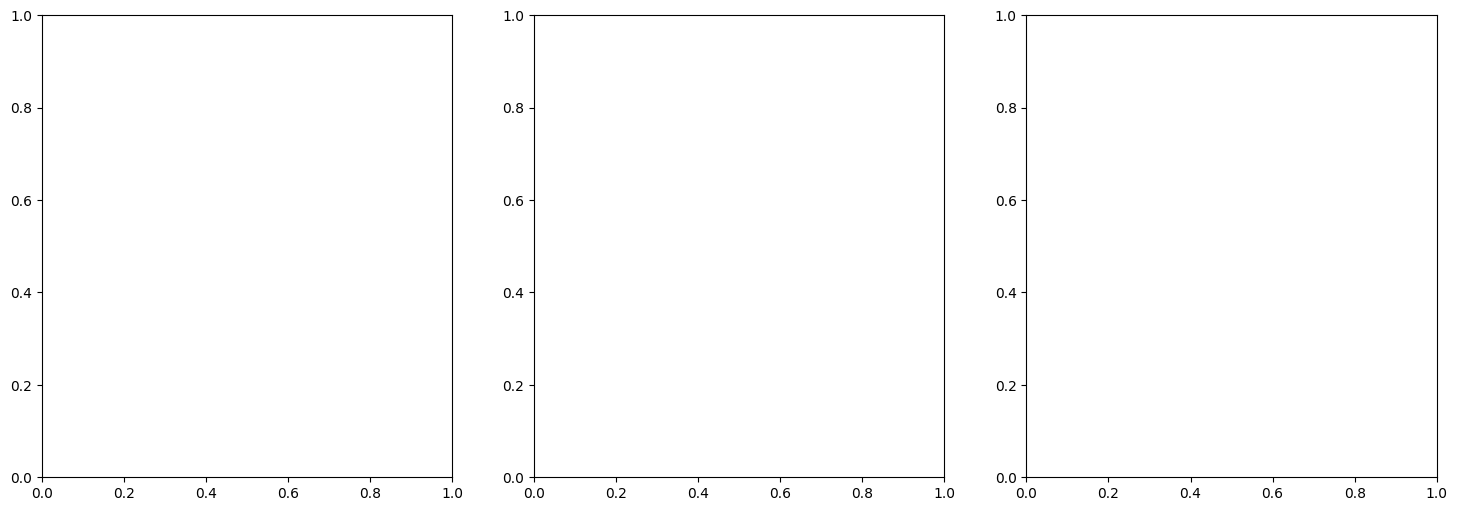

In [47]:
# Visualization 1: SI/TI scatter plot colored by algorithm
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: SI/TI space
for algo in sorted(df['condition'].unique()):
    subset = df[df['condition'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

# Plot 2: SI/TI colored by MOS
scatter = axes[1].scatter(df['SI_mean'], df['TI_mean'], 
                         c=df['MOS'], cmap='RdYlGn', 
                         s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Colored by MOS Score', fontsize=13)
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('MOS Score', fontsize=11)
axes[1].grid(alpha=0.3, linestyle='--')


for source in sorted(df['Source'].unique()):
    subset = df[df['Source'] == source]
    scatter = axes[2].scatter(subset['SI_mean'], subset['TI_mean'],  label = source, 
                             alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[2].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[2].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[2].set_title('SI-TI Space: Video Content Characterization by Source', fontsize=13)
axes[2].grid(alpha=0.3, linestyle='--')
axes[2].legend(loc='right', fontsize=9)


plt.tight_layout()
plt.show()

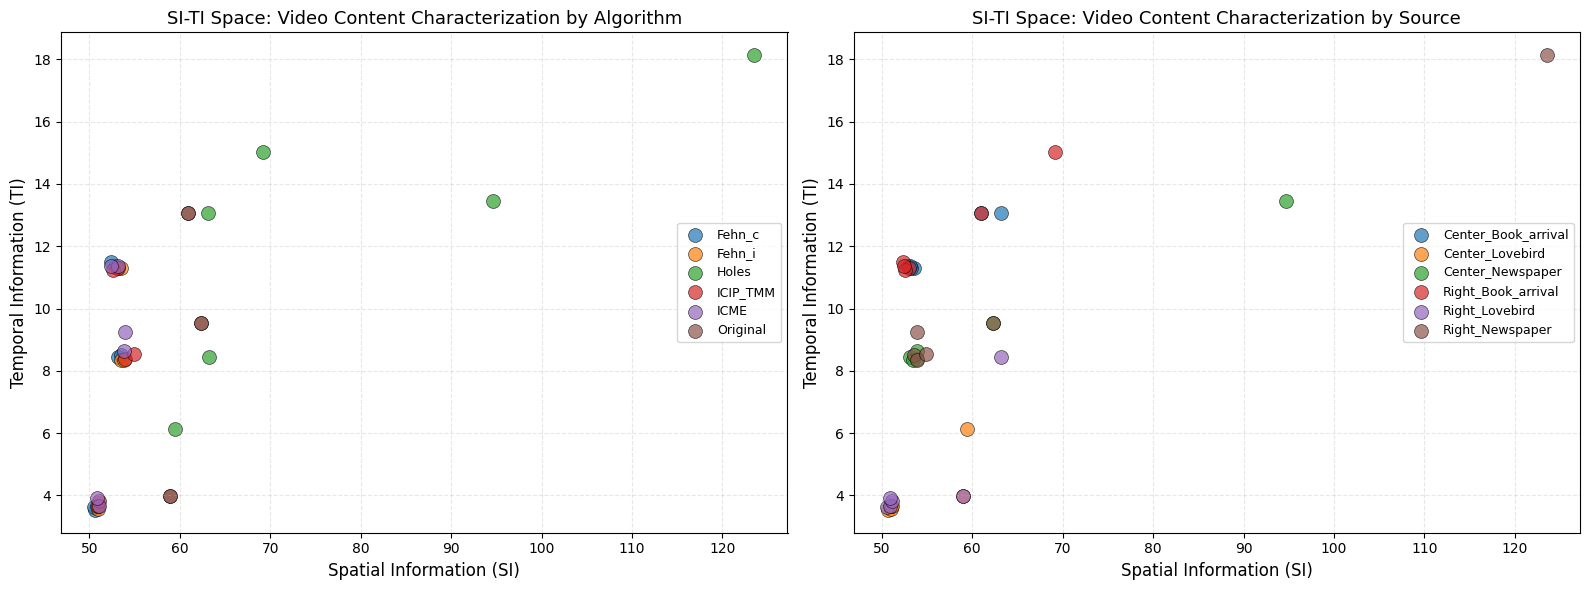

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for algo in sorted(df['condition'].unique()):
    subset = df[df['condition'] == algo]
    axes[0].scatter(subset['SI_mean'], subset['TI_mean'], 
                   label=algo, alpha=0.7, s=100, edgecolors='black', linewidth=0.5)

axes[0].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[0].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[0].set_title('SI-TI Space: Video Content Characterization by Algorithm', fontsize=13)
axes[0].legend(loc='right', fontsize=9)
axes[0].grid(alpha=0.3, linestyle='--')

for source in sorted(df['Source'].unique()):
    subset = df[df['Source'] == source]
    scatter = axes[1].scatter(subset['SI_mean'], subset['TI_mean'],  label = source, 
                             alpha=0.7, s=100, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Spatial Information (SI)', fontsize=12)
axes[1].set_ylabel('Temporal Information (TI)', fontsize=12)
axes[1].set_title('SI-TI Space: Video Content Characterization by Source', fontsize=13)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].legend(loc='right', fontsize=9)

plt.tight_layout()
plt.show()

## Objective QA : SSIM, MS-SSIM, LPIPS, VIFP

#### Metrics

In [55]:
def video_ssim(path_ref, path_dis, frame_sample_rate=1):
    """
    Compute SSIM for a video frame by frame.
    
    Parameters:
    - path_ref: reference video path
    - path_dis: distorted video path
    - frame_sample_rate: sample every Nth frame (1 = all frames)
    
    Returns:
    - mean SSIM score across all frames (higher is better, max=1.0)
    """
    cap_ref = cv.VideoCapture(path_ref)
    cap_dis = cv.VideoCapture(path_dis)
    scores = []
    frame_idx = 0

    while True:
        ret_r, f_ref = cap_ref.read()
        ret_d, f_dis = cap_dis.read()
        if not ret_r or not ret_d:
            break
        
        # Sample frames
        if frame_idx % frame_sample_rate != 0:
            frame_idx += 1
            continue
        
        frame_idx += 1

        # Convert to grayscale for SSIM computation
        gray_ref = cv.cvtColor(f_ref, cv.COLOR_BGR2GRAY)
        gray_dis = cv.cvtColor(f_dis, cv.COLOR_BGR2GRAY)

        # Compute SSIM using skimage
        score = ssim(gray_ref, gray_dis, data_range=255)
        scores.append(score)

    cap_ref.release()
    cap_dis.release()
    return np.mean(scores) if scores else None

def video_msssim(path_ref, path_dis, device='cpu', frame_sample_rate=1):
    """
    Compute MS-SSIM (Multi-Scale SSIM) for a video using PyTorch.
    
    Parameters:
    - path_ref: reference video path
    - path_dis: distorted video path
    - device: 'cpu' or 'cuda'
    - frame_sample_rate: sample every Nth frame (1 = all frames)
    
    Returns:
    - mean MS-SSIM score across all frames (higher is better, max=1.0)
    """
    if device == 'cpu' and torch.cuda.is_available():
        device = 'cuda'
        print("Using GPU for MS-SSIM computation")
    
    cap_ref = cv.VideoCapture(path_ref)
    cap_dis = cv.VideoCapture(path_dis)
    scores = []
    frame_idx = 0

    while True:
        ret_r, f_ref = cap_ref.read()
        ret_d, f_dis = cap_dis.read()
        if not ret_r or not ret_d:
            break
        
        # Sample frames
        if frame_idx % frame_sample_rate != 0:
            frame_idx += 1
            continue
        
        frame_idx += 1

        # Convert BGR to RGB
        f_ref = cv.cvtColor(f_ref, cv.COLOR_BGR2RGB)
        f_dis = cv.cvtColor(f_dis, cv.COLOR_BGR2RGB)

        # Normalize to [0, 1] for piq
        f_ref_normalized = f_ref.astype(np.float32) / 255.0
        f_dis_normalized = f_dis.astype(np.float32) / 255.0

        # Convert to tensors (B, C, H, W) - use torch.tensor to avoid numpy type issues
        tensor_ref = torch.tensor(f_ref_normalized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
        tensor_dis = torch.tensor(f_dis_normalized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

        with torch.no_grad():
            score = piq.multi_scale_ssim(tensor_ref, tensor_dis, data_range=1.0)
            scores.append(score.item())

    cap_ref.release()
    cap_dis.release()
    return np.mean(scores) if scores else None

In [56]:
loss_fn_alex = lpips.LPIPS(net='vgg') 

def video_lpips(path_ref, path_dis, device='cpu', frame_sample_rate=10):
    """
    Compute LPIPS for a video with frame sampling for optimization.
    
    Parameters:
    - path_ref: reference video path
    - path_dis: distorted video path
    - device: 'cpu' or 'cuda' (use GPU if available)
    - frame_sample_rate: sample every Nth frame (10 = process 10% of frames)
    """
    if device == 'cpu' and torch.cuda.is_available():
        device = 'cuda'
        print("Using GPU for LPIPS computation")
    
    cap_ref = cv.VideoCapture(path_ref)
    cap_dis = cv.VideoCapture(path_dis)
    scores = []
    frame_idx = 0

    while True:
        ret_r, f_ref = cap_ref.read()
        ret_d, f_dis = cap_dis.read()
        if not ret_r or not ret_d:
            break
        
        # Sample frames: only process every Nth frame
        if frame_idx % frame_sample_rate != 0:
            frame_idx += 1
            continue
        
        frame_idx += 1

        f_ref = cv.cvtColor(f_ref, cv.COLOR_BGR2RGB)
        f_dis = cv.cvtColor(f_dis, cv.COLOR_BGR2RGB)


        f_ref_normalized = (f_ref / 127.5) - 1.0
        f_dis_normalized = (f_dis / 127.5) - 1.0

        tensor_ref = torch.tensor(f_ref_normalized, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)
        tensor_dis = torch.tensor(f_dis_normalized, dtype=torch.float32).permute(2,0,1).unsqueeze(0).to(device)

        with torch.no_grad():
            d = loss_fn_alex(tensor_ref, tensor_dis)
            scores.append(d.item())

    cap_ref.release()
    cap_dis.release()
    return np.mean(scores) if scores else None

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


c:\Users\Marie\Documents\info m2 local\Quality of Experience\projet\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Marie\Documents\info m2 local\Quality of Experience\projet\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Marie\Documents\info m2 local\Quality of Experience\projet\venv\Lib\site-packages\lpips\weights\v0.1\vgg.pth


In [57]:
def video_vifp(path_ref, path_dis, device='cpu', frame_sample_rate=1):
    """
    Compute VIFP (Visual Information Fidelity in Pixel domain) for a video.
    
    Parameters:
    - path_ref: reference video path
    - path_dis: distorted video path
    - device: 'cpu' or 'cuda'
    - frame_sample_rate: sample every Nth frame (1 = all frames)
    
    Returns:
    - mean VIFP score across all frames (higher is better)
    """
    if device == 'cpu' and torch.cuda.is_available():
        device = 'cuda'
        print("Using GPU for VIFP computation")
    
    cap_ref = cv.VideoCapture(path_ref)
    cap_dis = cv.VideoCapture(path_dis)
    scores = []
    frame_idx = 0

    while True:
        ret_r, f_ref = cap_ref.read()
        ret_d, f_dis = cap_dis.read()
        if not ret_r or not ret_d:
            break
        
        # Sample frames
        if frame_idx % frame_sample_rate != 0:
            frame_idx += 1
            continue
        
        frame_idx += 1

        # Convert BGR to RGB
        f_ref = cv.cvtColor(f_ref, cv.COLOR_BGR2RGB)
        f_dis = cv.cvtColor(f_dis, cv.COLOR_BGR2RGB)

        # Normalize to [0, 1] for piq
        f_ref_normalized = f_ref.astype(np.float32) / 255.0
        f_dis_normalized = f_dis.astype(np.float32) / 255.0

        # Convert to tensors (B, C, H, W) - ensure arrays are contiguous
        f_ref_contiguous = np.ascontiguousarray(f_ref_normalized)

        tensor_ref = torch.from_numpy(f_ref_contiguous).permute(2, 0, 1).unsqueeze(0).to(device)
        f_dis_contiguous = np.ascontiguousarray(f_dis_normalized)

        tensor_dis = torch.from_numpy(f_dis_contiguous).permute(2, 0, 1).unsqueeze(0).to(device)

        # tensor_ref = torch.tensor(f_ref_normalized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
        # tensor_dis = torch.tensor(f_dis_normalized, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

        with torch.no_grad():
            score = piq.vif_p(tensor_ref, tensor_dis, data_range=1.0)
            scores.append(score.item())

    cap_ref.release()
    cap_dis.release()
    return np.mean(scores) if scores else None

#### Computation

In [58]:
df['SSIM'] = np.nan
df['MS_SSIM'] = np.nan
df['LPIPS'] = np.nan
df['VIFP'] = np.nan

print("Computing objective quality metrics...\n")

# Count videos to process (excluding Originals)
videos_to_process = df[(df['condition'] != 'Original') & (~df['ref_video_path'].isna())]
total_videos = len(videos_to_process)

# Create progress bar
pbar = tqdm(total=total_videos, desc="Processing videos", unit="video")
start_time_total = time.time()

processed = 0
for index, row in df.iterrows():
    video_name = row['Video_path']
    video_path = os.path.join(VIDEOS_PATH, video_name)

    if row['condition'] == 'Original':
        df.at[index, 'SSIM'] = np.nan
        df.at[index, 'LPIPS'] = np.nan
        df.at[index, 'VIFP'] = np.nan
        df.at[index, 'MS_SSIM'] = np.nan
        continue

    ref_video_name = row['ref_video_path']
    if pd.isna(ref_video_name):
        continue
    
    video_ref_path = os.path.join(VIDEOS_PATH, ref_video_name)

    if os.path.exists(video_path) and os.path.exists(video_ref_path):
        processed += 1
        start_video = time.time()
        
        # Update progress bar description with current video
        pbar.set_description(f"Processing {video_name[:30]}...")
        
        # Compute metrics with frame sampling for efficiency
        frame_sample = 15 # every Nth frame
        
        ssim_score = video_ssim(video_ref_path, video_path, frame_sample_rate=frame_sample)
        ms_ssim_score = video_msssim(video_ref_path, video_path, frame_sample_rate=frame_sample)
        lpips_score = video_lpips(video_ref_path, video_path, frame_sample_rate=frame_sample)
        vifp_score = video_vifp(video_ref_path, video_path, frame_sample_rate=frame_sample)

        df.at[index, 'SSIM'] = ssim_score
        df.at[index, 'MS_SSIM'] = ms_ssim_score
        df.at[index, 'LPIPS'] = lpips_score
        df.at[index, 'VIFP'] = vifp_score
        
        # Calculate elapsed time and update postfix with metrics and time info
        video_time = time.time() - start_video
        elapsed_total = time.time() - start_time_total
        avg_time = elapsed_total / processed
        
        pbar.set_postfix({
            'SSIM': f'{ssim_score:.3f}',
            'LPIPS': f'{lpips_score:.3f}',
            'time': f'{video_time:.1f}s',
            'avg': f'{avg_time:.1f}s/vid'
        })
        pbar.update(1)
    else:
        if not os.path.exists(video_path):
            tqdm.write(f"  Video not found: {video_path}")
        if not os.path.exists(video_ref_path):
            tqdm.write(f"  Reference not found: {video_ref_path}")

pbar.close()

total_time = time.time() - start_time_total
print(f"\n{'='*70}")
print(f"Objective metrics computed (SSIM + MS-SSIM + LPIPS + VIFP).")
print(f"Total time: {total_time/60:.2f} min | Avg: {total_time/processed:.1f}s/video")
print(f"{'='*70}\n")

df[['video', 'condition', 'MOS', 'SSIM', 'MS_SSIM', 'LPIPS', 'VIFP']].head(10)

Computing objective quality metrics...



Processing Newspaper_A5_4_to_6.avi...: 100%|██████████| 30/30 [36:45<00:00, 73.53s/video, SSIM=0.785, LPIPS=0.241, time=102.7s, avg=73.5s/vid]   


Objective metrics computed (SSIM + MS-SSIM + LPIPS + VIFP).
Total time: 36.76 min | Avg: 73.5s/video



,video,condition,MOS,SSIM,MS_SSIM,LPIPS,VIFP
0,Center_Book_arrival,Fehn_c,75.857143,0.652634,0.664110,0.367125,0.110540
1,Center_Book_arrival,Fehn_i,73.214286,0.891665,0.936387,0.217637,0.468095
2,Center_Book_arrival,Holes,36.357143,0.872833,0.917842,0.239128,0.463828
3,Center_Book_arrival,ICIP_TMM,67.714286,0.905453,0.943711,0.205282,0.510933
4,Center_Book_arrival,ICME,60.000000,0.905126,0.943304,0.205670,0.510381
5,Center_Book_arrival,Original,91.642857,NaN,NaN,NaN,NaN
6,Center_Lovebird,Fehn_c,75.285714,0.842555,0.900219,0.220701,0.398528
7,Center_Lovebird,Fehn_i,76.357143,0.826396,0.901152,0.212660,0.385179
8,Center_Lovebird,Holes,41.214286,0.821893,0.893710,0.228312,0.380059
9,Center_Lovebird,ICIP_TMM,52.857143,0.827375,0.898843,0.212891,0.388465


In [59]:
df.to_csv(output_file, index=False)
print(f"Data saved to: {output_file}")
print(f"Rows saved: {len(df)}")
print(f"Columns saved: {list(df.columns)}")

Data saved to: results/experimental_results.csv
Rows saved: 36
Columns saved: ['Video_path', 'from_video_path', 'ref_video_path', 'video', 'Source', 'condition', 'rating_Elliot', 'rating_Enzo', 'rating_HU', 'rating_LEI', 'rating_VEDRAN', 'rating_ZEKAI', 'rating_christopher', 'rating_cla', 'rating_corgi', 'rating_emerik', 'rating_gabin', 'rating_lou-anne', 'rating_malo', 'rating_maria', 'MOS', 'DMOS', 'CI_95', 'SI_mean', 'SI_max', 'TI_mean', 'TI_max', 'SI_p95', 'TI_p95', 'SSIM', 'MS_SSIM', 'LPIPS', 'VIFP']


### Analysis

#### Pearson and Spearman correlations

In [61]:
#imported from coeff_func.py from tp2

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
from scipy.optimize import fmin
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.optimize import leastsq
def logistic(t, x):
    return 0.5 - (1 / (1 + np.exp(t * x)))

def fitfun(t, x):
    res = t[0] * (logistic(t[1], (x-t[2]))) + t[3] + t[4] * x
    return res

def errfun(t, x, y):
    return np.sum(np.power(y - fitfun(t, x),2))

def RMSE(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse  

def coeff_fit(Obj,y) :
    temp = pearsonr(Obj, y)
    t = np.zeros(5)
    t[2] = np.mean(Obj)
    t[3] = np.mean(y)
    t[1] = 1/np.std(Obj)
    t[0] = abs(np.max(y) - np.min(y))    
    t[4] = -1
    signslope = 1
    if temp[1]<=0:
        t[0] *= -1
        signslope *= -1     
    v = [t, Obj, y]
    tt = fmin(errfun, t, args=(Obj, y))
    fit = fitfun(tt, Obj)
    cc = pearsonr(fit, y)[0]
    srocc = spearmanr(fit, y).correlation
    krocc = kendalltau(fit, y).correlation
    rmse = RMSE( np.absolute(y), np.absolute(fit) )
    return  fit, cc, srocc, krocc, rmse
 

In [ ]:
# Filter out NaN values for analysis (only non-Original videos have objective metrics)
df_metrics = df[df['condition'] != 'Original'].copy()
df_metrics = df_metrics.dropna(subset=['SSIM', 'LPIPS', 'VIFP', 'MS_SSIM', 'MOS'])

In [ ]:
results = {}
metrics_to_analyze = ['SSIM', 'MS_SSIM', 'LPIPS', 'VIFP']

for metric in metrics_to_analyze:
    valid_data = df_metrics[[metric, 'MOS']].dropna()
    
    if len(valid_data) < 3:
        print(f"{metric}: Not enough data points ({len(valid_data)})")
        continue
    
    fit_mos, cc, srocc, krocc, rmse = coeff_fit(
        valid_data[metric].values, 
        valid_data['MOS'].values
    )

    df_metrics.loc[valid_data.index, f'MOS_fit_{metric}'] = fit_mos
    
    results[metric] = {
        'pearson_fitted': cc,
        'spearman_fitted': srocc,
        'kendall_fitted': krocc,
        'rmse': rmse,
        'samples': len(valid_data)
    }
    
    print(f"{metric}:")
    print(f"  Samples: {len(valid_data)}")
    print(f"  Fitted Pearson (r):  {cc:.4f}")
    print(f"  Fitted Spearman (ρ): {srocc:.4f}")
    print(f"  Fitted Kendall (τ):  {krocc:.4f}")
    print(f"  RMSE: {rmse:.4f}\n")

SSIM:
  Samples: 30
  Fitted Pearson (r):  0.2984
  Fitted Spearman (ρ): 0.2619
  Fitted Kendall (τ):  0.1820
  RMSE: 14.4649

MS_SSIM:
  Samples: 30
  Fitted Pearson (r):  0.5739
  Fitted Spearman (ρ): 0.5476
  Fitted Kendall (τ):  0.4171
  RMSE: 12.4113

LPIPS:
  Samples: 30
  Fitted Pearson (r):  0.4227
  Fitted Spearman (ρ): 0.5113
  Fitted Kendall (τ):  0.3756
  RMSE: 13.7348

VIFP:
  Samples: 30
  Fitted Pearson (r):  0.2117
  Fitted Spearman (ρ): 0.1286
  Fitted Kendall (τ):  0.0853
  RMSE: 14.8116



C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\96858281.py:38: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  tt = fmin(errfun, t, args=(Obj, y))
C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\96858281.py:12: RuntimeWarning: overflow encountered in exp
  return 0.5 - (1 / (1 + np.exp(t * x)))
C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\96858281.py:38: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  tt = fmin(errfun, t, args=(Obj, y))
C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\96858281.py:38: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  tt = fmin(errfun, t, args=(Obj, y))
C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\96858281.py:38: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  tt = fmin(errfun, t, args=(Obj, y))


In [ ]:
output_file2 = os.path.join(SAVE_PATH, "df_metrics.csv")
df_metrics.to_csv(output_file2, index=False)
print(f"Data saved to: {output_file2}")
print(f"Rows saved: {len(df_metrics)}")
print(f"Columns saved: {list(df_metrics.columns)}")

#### Plots of the correlations (matrix, scatterplots)

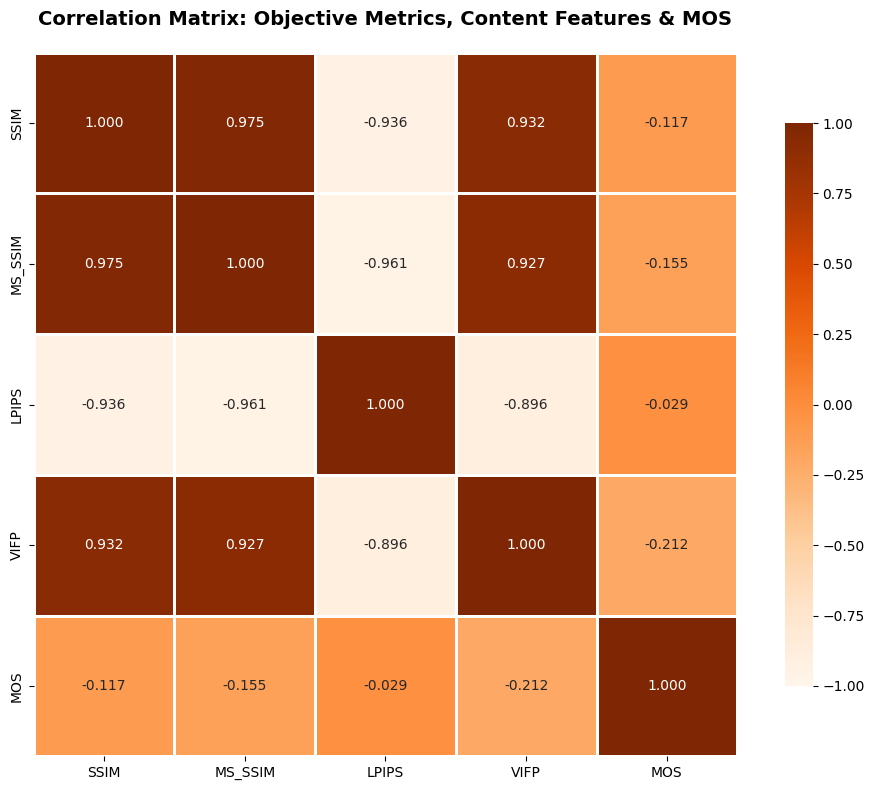


Correlation Matrix with MOS (Subjective Quality):
----------------------------------------------------------------------
MOS        1.000000
LPIPS     -0.029373
SSIM      -0.116969
MS_SSIM   -0.155061
VIFP      -0.211699
Name: MOS, dtype: float64


In [ ]:
#### Unifited MOS !!!

fig, ax = plt.subplots(figsize=(10, 8))

metrics_list = ['SSIM', 'MS_SSIM', 'LPIPS', 'VIFP', 'MOS']
corr_matrix = df_metrics[metrics_list].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='Oranges', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Correlation Matrix: Objective Metrics, Content Features & MOS (unfit)', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix with MOS (Subjective Quality):")
print("-" * 70)
print(corr_matrix['MOS'].sort_values(ascending=False))

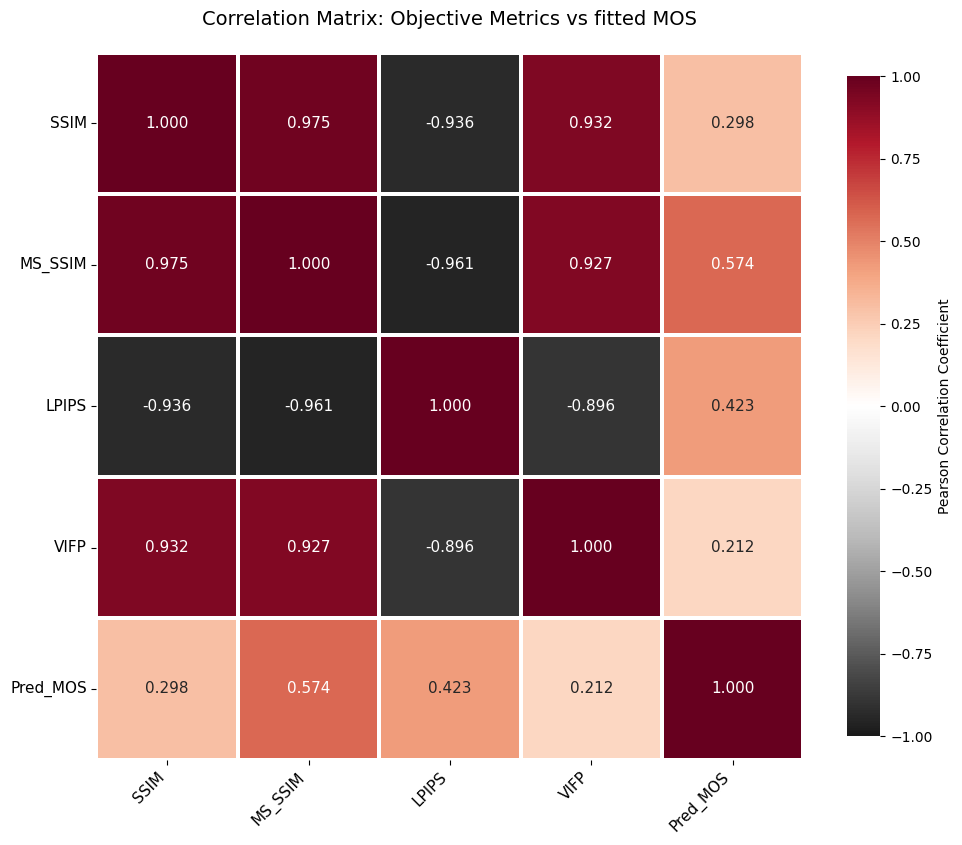


QUALITÉ DU FIT: Real_MOS vs Pred_MOS de chaque métrique
--------------------------------------------------------------------------------
SSIM         → Real_MOS vs Pred_MOS(SSIM    ): r = +0.2984
MS_SSIM      → Real_MOS vs Pred_MOS(MS_SSIM ): r = +0.5739
LPIPS        → Real_MOS vs Pred_MOS(LPIPS   ): r = +0.4227
VIFP         → Real_MOS vs Pred_MOS(VIFP    ): r = +0.2117

COMPARAISON: Avant fit vs Après fit logistique
--------------------------------------------------------------------------------
Métrique     Avant fit       Après fit       Amélioration
--------------------------------------------------------------------------------
SSIM         -0.1170          +0.2984          +0.4154
MS_SSIM      -0.1551          +0.5739          +0.7289
LPIPS        -0.0294          +0.4227          +0.4520
VIFP         -0.2117          +0.2117          +0.4234


In [ ]:
fig, ax = plt.subplots(figsize=(10, 9))

metrics_obj = ['SSIM', 'MS_SSIM', 'LPIPS', 'VIFP']
metrics_fit = ['MOS_fit_SSIM', 'MOS_fit_MS_SSIM', 'MOS_fit_LPIPS', 'MOS_fit_VIFP']

import pandas as pd
corr_matrix_custom = pd.DataFrame(
    index=metrics_obj + ['Pred_MOS'],
    columns=metrics_obj + ['Pred_MOS']
)

corr_obj = df_metrics[metrics_obj].corr()
for i, m1 in enumerate(metrics_obj):
    for j, m2 in enumerate(metrics_obj):
        corr_matrix_custom.iloc[i, j] = corr_obj.loc[m1, m2]

# MAT[métrique, Pred_MOS] = corrélation(Real_MOS, Pred_MOS_métrique)
for i, (metric, fit_metric) in enumerate(zip(metrics_obj, metrics_fit)):
    corr_val = df_metrics[['MOS', fit_metric]].corr().iloc[0, 1]
    corr_matrix_custom.iloc[i, 4] = corr_val
    corr_matrix_custom.iloc[4, i] = corr_val

corr_matrix_custom.iloc[4, 4] = 1.0
corr_matrix_custom = corr_matrix_custom.astype(float)

sns.heatmap(corr_matrix_custom, annot=True, fmt='.3f', cmap='RdGy_r', center=0,
            square=True, linewidths=1.5, cbar_kws={"shrink": 0.8, "label": "Pearson Correlation Coefficient"},
            vmin=-1, vmax=1, ax=ax, 
            annot_kws={'size': 11})

ax.set_title('Correlation Matrix: Objective Metrics vs fitted MOS', 
             fontsize=14, pad=20)

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.tight_layout()
plt.show()

print("\nQUALITY OF FIT: Real_MOS vs Pred_MOS of each metric")
print("-"*80)
for metric, fit_metric in zip(metrics_obj, metrics_fit):
    corr_value = corr_matrix_custom.loc[metric, 'Pred_MOS']
    print(f"{metric:12} → Real_MOS vs Pred_MOS({metric:8}): r = {corr_value:+.4f}")
print("="*80)

print("\nCOMPARISON: Before fit vs After logistic fit")
print("-"*80)
print(f"{'Metric':<12} {'Before fit':<15} {'After fit':<15} {'difference'}")
print("-"*80)
for metric, fit_metric in zip(metrics_obj, metrics_fit):
    before = df_metrics[[metric, 'MOS']].corr().iloc[0, 1]
    after = corr_matrix_custom.loc[metric, 'Pred_MOS']
    improvement = after - before
    print(f"{metric:<12} {before:+.4f}          {after:+.4f}          {improvement:+.4f}")
print("="*80)

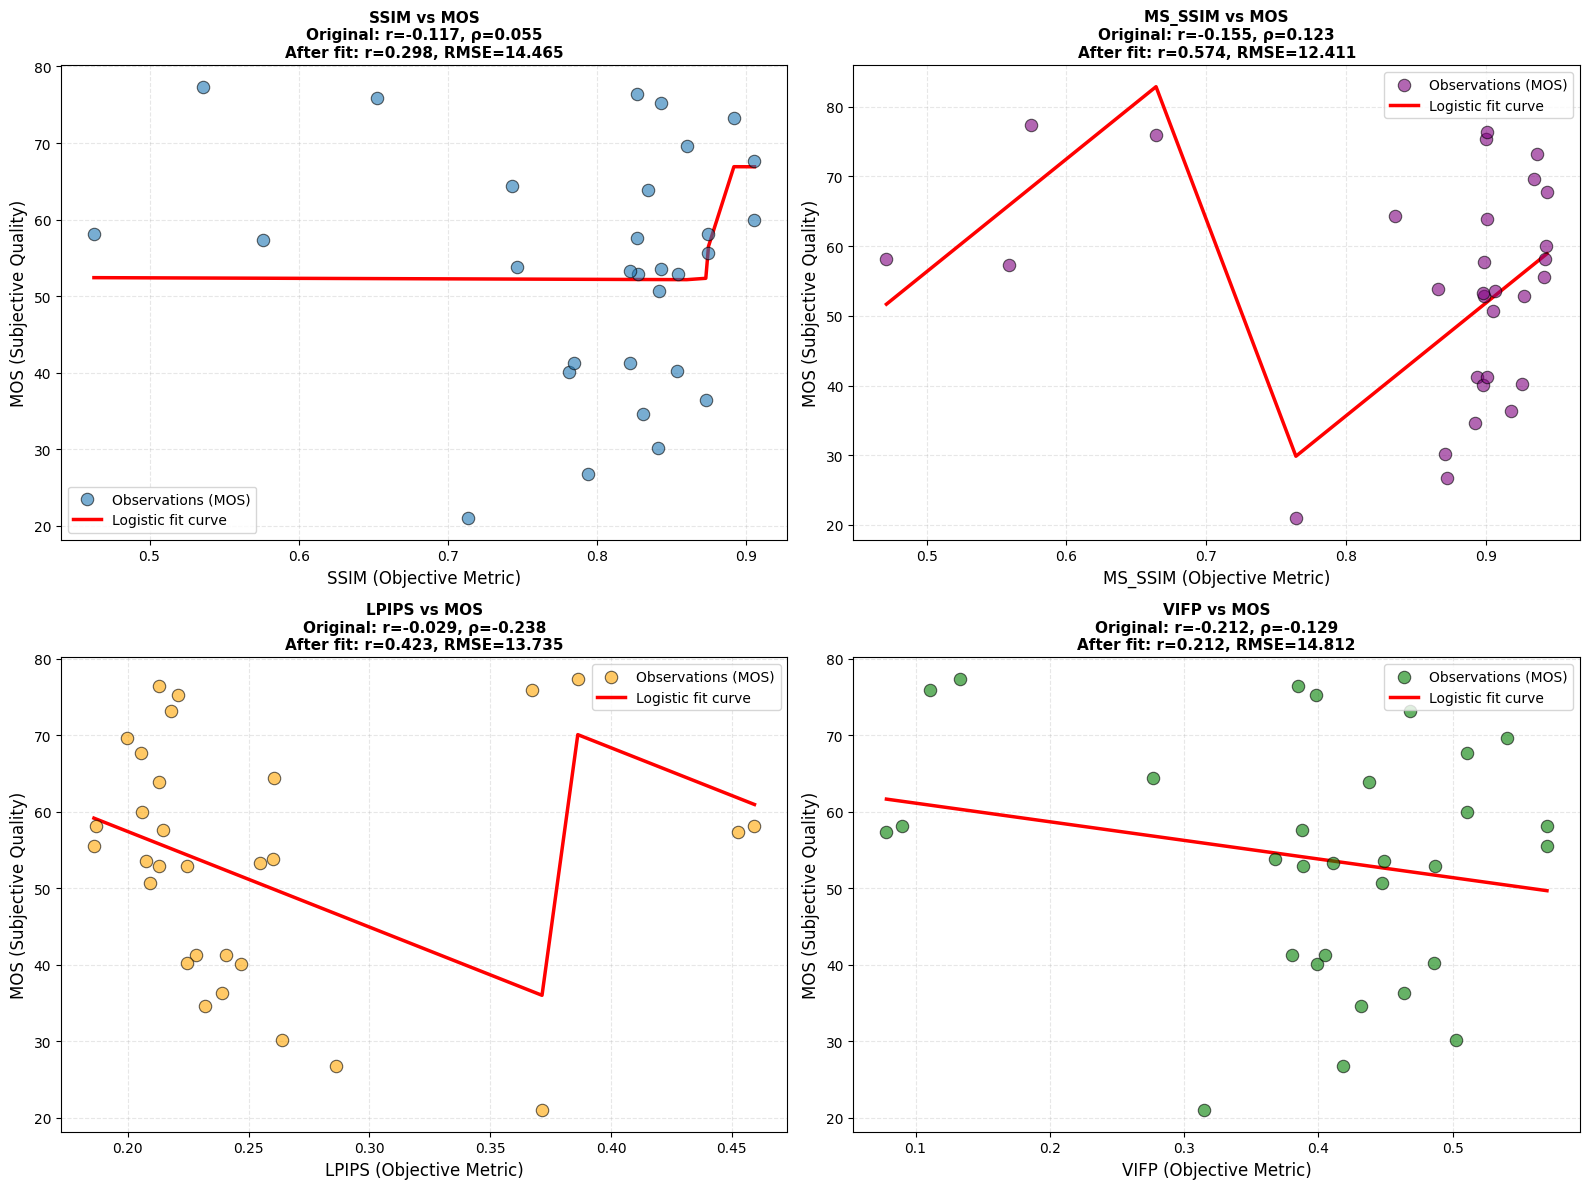

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

colors_map = {
    'SSIM': 'tab:blue',       # blue
    'MS_SSIM': 'purple',      # purple
    'LPIPS': 'orange',        # orange
    'VIFP': 'green'           # green
}

for idx, metric in enumerate(metrics_to_analyze):
    ax = axes[idx // 2, idx % 2]
    fit_col = f'MOS_fit_{metric}'
    color = colors_map[metric]
    
    # scatterplot
    ax.scatter(df_metrics[metric], df_metrics['MOS'], 
               alpha=0.6, s=80, label='Observations (MOS)', 
               color=color, edgecolors='black', linewidth=0.8, zorder=3)
    
    # fit
    sorted_indices = df_metrics[metric].argsort()
    metric_sorted = df_metrics[metric].iloc[sorted_indices]
    fit_sorted = df_metrics[fit_col].iloc[sorted_indices]
    
    ax.plot(metric_sorted, fit_sorted, 'r-', linewidth=2.5, 
            label='Logistic fit curve', zorder=2)
    
    # correlations
    from scipy.stats import pearsonr, spearmanr
    pearson_r = pearsonr(df_metrics[metric], df_metrics['MOS'])[0]
    spearman_r = spearmanr(df_metrics[metric], df_metrics['MOS'])[0]
    pearson_fit = pearsonr(df_metrics[fit_col], df_metrics['MOS'])[0]
    
    # RMSE
    rmse = np.sqrt(np.mean((df_metrics['MOS'] - df_metrics[fit_col])**2))
    
    ax.set_xlabel(f'{metric} (Objective Metric)', fontsize=12)
    ax.set_ylabel('MOS (Subjective Quality)', fontsize=12)
    ax.set_title(f'{metric} vs MOS\n' + 
                 f'Original: r={pearson_r:.3f}, ρ={spearman_r:.3f}\n' +
                 f'After fit: r={pearson_fit:.3f}, RMSE={rmse:.3f}',
                 fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.show()

#### Impact of video type and algorithm on metrics 

CONTENT IMPACT

Book_arrival:
  Samples: 10
  MOS: 54.350 ± 16.084
  SSIM: 0.813 ± 0.112
  MS-SSIM: 0.859 ± 0.134
  LPIPS: 0.268 ± 0.081
  VIFP: 0.394 ± 0.162

Lovebird1:
  Samples: 10
  MOS: 57.036 ± 13.467
  SSIM: 0.824 ± 0.029
  MS-SSIM: 0.893 ± 0.021
  LPIPS: 0.221 ± 0.016
  VIFP: 0.398 ± 0.051

Newspaper:
  Samples: 10
  MOS: 50.500 ± 17.365
  SSIM: 0.747 ± 0.143
  MS-SSIM: 0.816 ± 0.165
  LPIPS: 0.280 ± 0.094
  VIFP: 0.389 ± 0.171


C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\3161023523.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_video, labels=source, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\3161023523.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_video, labels=source, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\3161023523.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_video, labels=source, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\3161023523.py:24: MatplotlibDeprecationWar

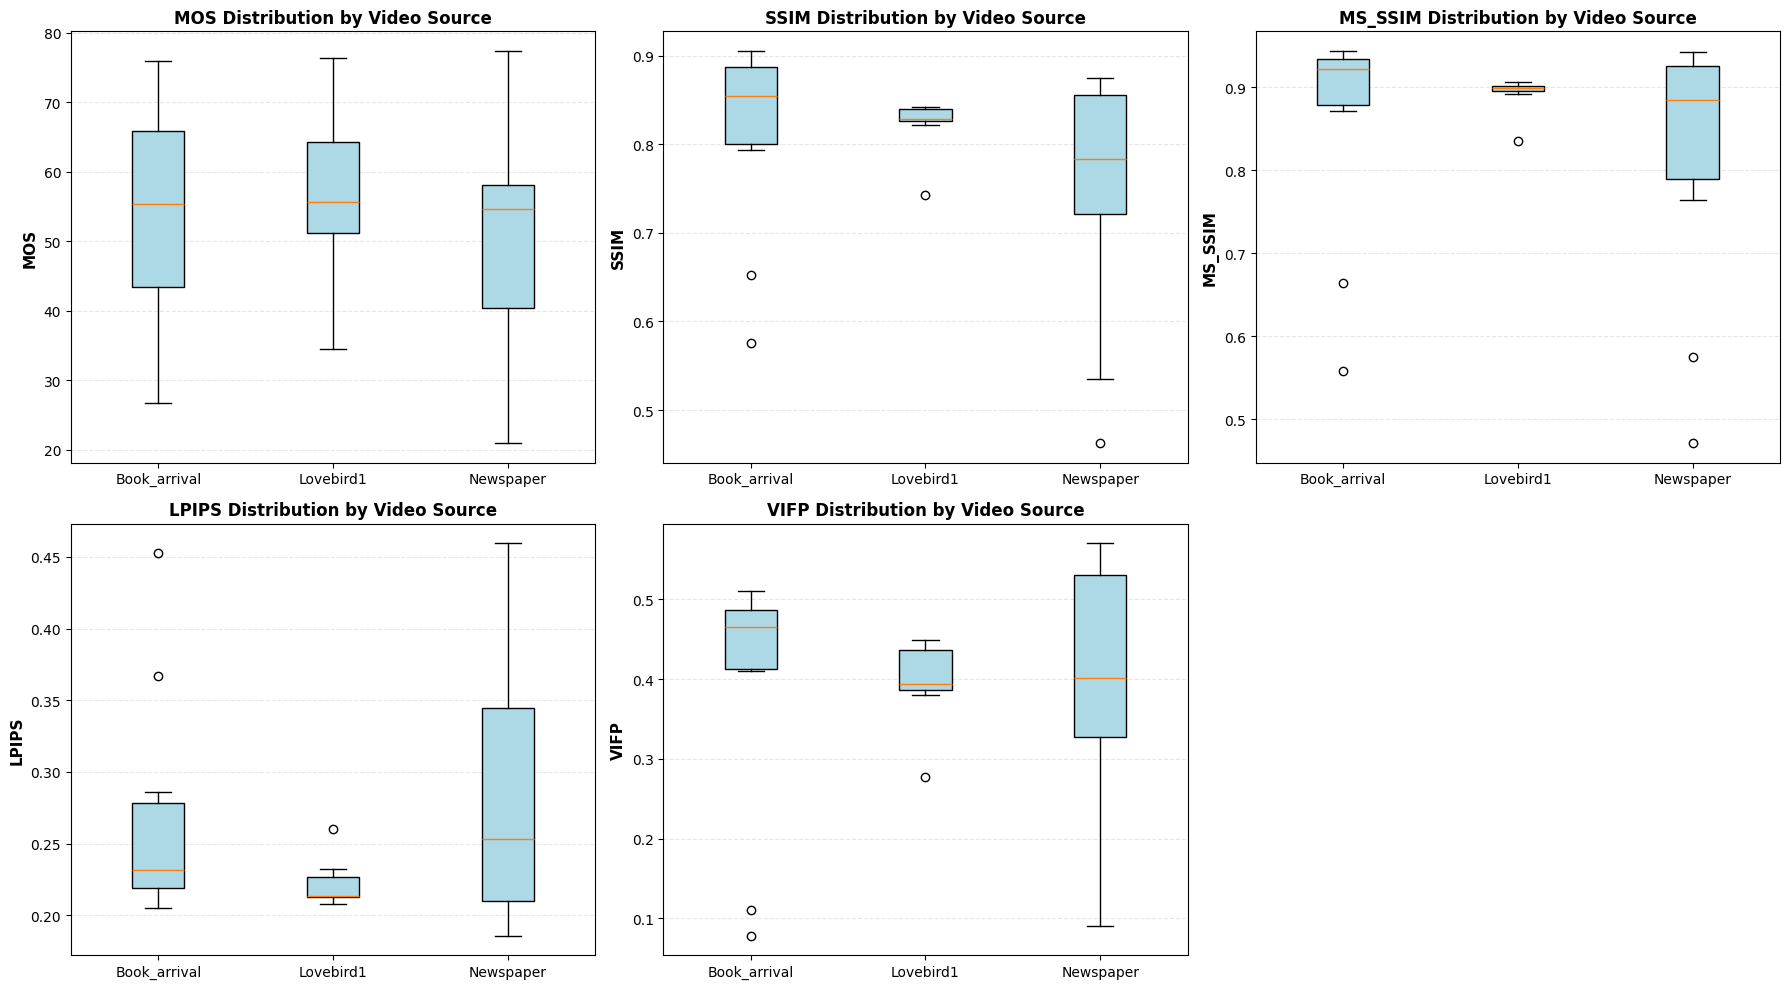


ALGORITHM IMPACT

Metric means and std by Algorithm:
               MOS            SSIM         MS_SSIM           LPIPS          \
              mean     std    mean     std    mean     std    mean     std   
condition                                                                    
Fehn_c     68.0476  9.2476  0.6354  0.1400  0.6673  0.1681  0.3577  0.0985   
Fehn_i     65.0119  9.8148  0.8301  0.0485  0.9060  0.0264  0.2263  0.0248   
Holes      31.6786  7.2389  0.8122  0.0547  0.8685  0.0539  0.2701  0.0543   
ICIP_TMM   54.1905  8.9581  0.8477  0.0423  0.9194  0.0210  0.2140  0.0203   
ICME       50.8810  8.4636  0.8477  0.0413  0.9194  0.0204  0.2135  0.0185   

             VIFP          
             mean     std  
condition                  
Fehn_c     0.1813  0.1286  
Fehn_i     0.4349  0.0628  
Holes      0.4185  0.0657  
ICIP_TMM   0.4673  0.0694  
ICME       0.4678  0.0684  


C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\3161023523.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_algo, labels=algos, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\3161023523.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_algo, labels=algos, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\3161023523.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_by_algo, labels=algos, patch_artist=True)
C:\Users\Marie\AppData\Local\Temp\ipykernel_9780\3161023523.py:56: MatplotlibDeprecationWarning: 

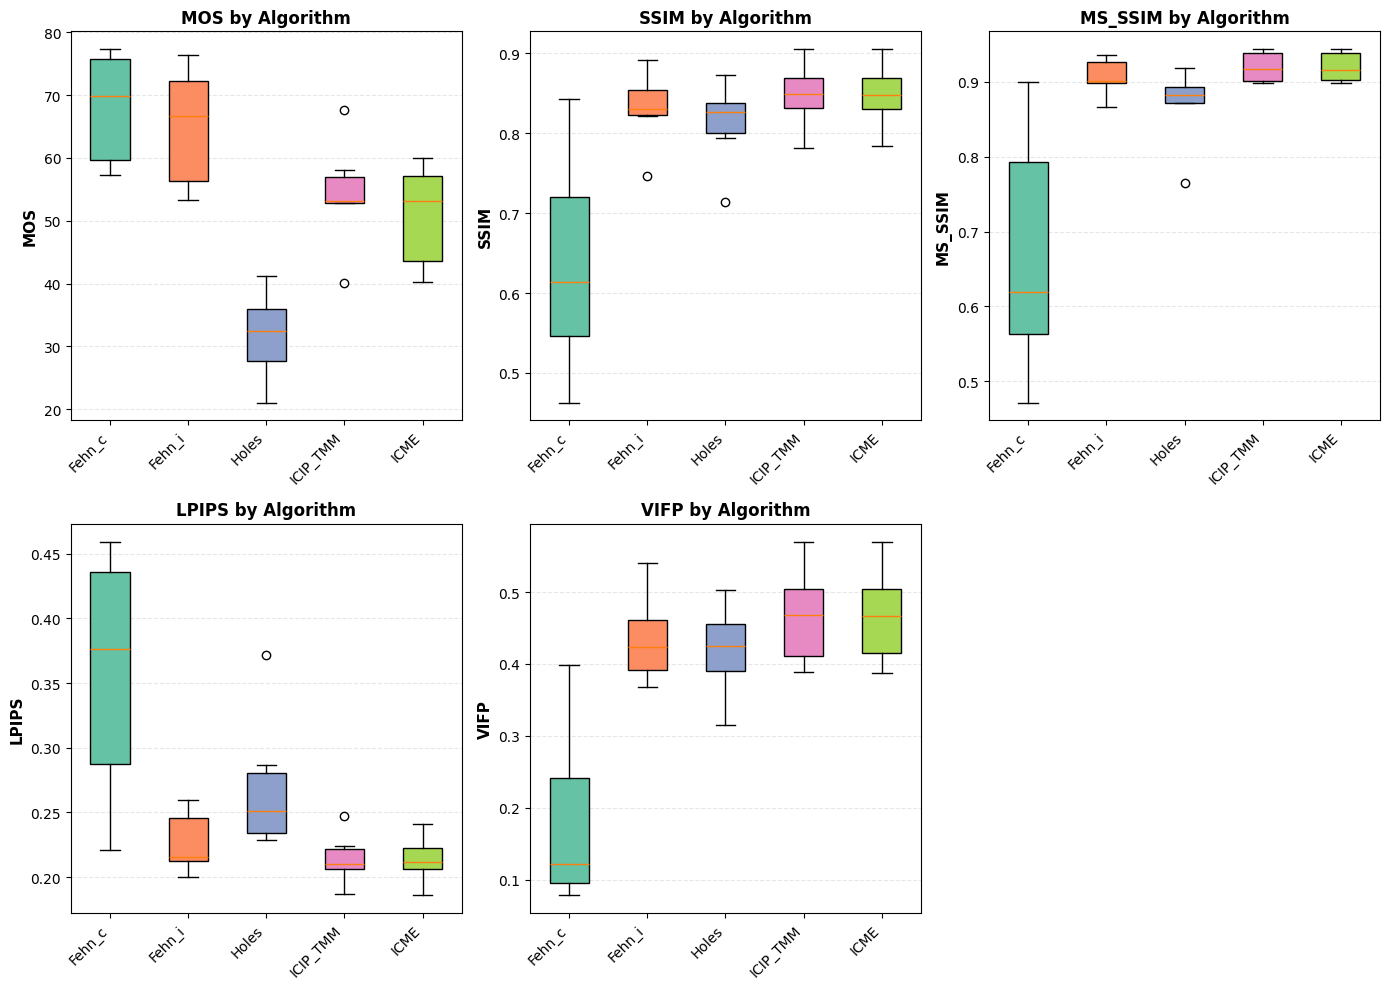


Algorithm ranking by MOS (subjective quality):
  Fehn_c          → 68.048
  Fehn_i          → 65.012
  ICIP_TMM        → 54.190
  ICME            → 50.881
  Holes           → 31.679


In [ ]:
print("CONTENT IMPACT")

for source in sorted(df_metrics['Source'].unique()):
    subset = df_metrics[df_metrics['Source'] == source]
    print(f"\n{source}:")
    print(f"  Samples: {len(subset)}")
    print(f"  MOS: {subset['MOS'].mean():.3f} ± {subset['MOS'].std():.3f}")
    print(f"  SSIM: {subset['SSIM'].mean():.3f} ± {subset['SSIM'].std():.3f}")
    print(f"  MS-SSIM: {subset['MS_SSIM'].mean():.3f} ± {subset['MS_SSIM'].std():.3f}")
    print(f"  LPIPS: {subset['LPIPS'].mean():.3f} ± {subset['LPIPS'].std():.3f}")
    print(f"  VIFP: {subset['VIFP'].mean():.3f} ± {subset['VIFP'].std():.3f}")

# Visualization: Metrics by video type
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics_to_plot = ['MOS', 'SSIM', 'MS_SSIM', 'LPIPS', 'VIFP']
for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    source = sorted(df_metrics['Source'].unique())
    data_by_video = [df_metrics[df_metrics['Source'] == vid][metric].values for vid in source]
    
    bp = ax.boxplot(data_by_video, labels=source, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Distribution by Video Source', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

# Algorithm impact
print("\n" + "="*70)
print("ALGORITHM IMPACT")
print("="*70)

algo_comparison = df_metrics.groupby('condition')[['MOS', 'SSIM', 'MS_SSIM', 'LPIPS', 'VIFP']].agg(['mean', 'std'])
print("\nMetric means and std by Algorithm:")
print(algo_comparison.round(4))

# Visualization: Metrics by algorithm
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

metrics_to_plot = ['MOS', 'SSIM', 'MS_SSIM', 'LPIPS', 'VIFP']
colors = sns.color_palette("Set2", len(df_metrics['condition'].unique()))

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 3, idx % 3]
    
    algos = sorted(df_metrics['condition'].unique())
    data_by_algo = [df_metrics[df_metrics['condition'] == algo][metric].values for algo in algos]
    
    bp = ax.boxplot(data_by_algo, labels=algos, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} by Algorithm', fontsize=12, fontweight='bold')
    ax.set_xticklabels(algos, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

print("\nAlgorithm ranking by MOS (subjective quality):")
for algo in sorted(df_metrics.groupby('condition')['MOS'].mean().sort_values(ascending=False).index, key=lambda x: df_metrics[df_metrics['condition'] == x]['MOS'].mean(), reverse=True):
    mean_mos = df_metrics[df_metrics['condition'] == algo]['MOS'].mean()
    print(f"  {algo:15} → {mean_mos:.3f}")

## Comparison with original paper's CI

In [ ]:
df_original = pd.read_excel("IRCCyN_IVC_DIBR_Videos_Scores.xlsx", skiprows=[0])

df_processed = pd.read_csv("results/df_videos_processed.csv")

ORIGINALS = ['Left']
REFERENCES = ['Center_Book_arrival', 'Right_Book_arrival',
              'Center_Lovebird',     'Right_Lovebird',
              'Center_Newspaper',    'Right_Newspaper']
CONDITIONS = ['Original', 'Fehn_c', 'Fehn_i', 'Holes', 'ICIP_TMM', 'ICME']

# Filter df_processed using find_video and predefined lists
selected_paths = []

for orig in ORIGINALS:
    for ref in REFERENCES:
        for cond in CONDITIONS:
            path = find_video(orig, ref, cond, df_processed)
            if path:
                selected_paths.append(path)

selected_paths = list(dict.fromkeys(selected_paths))  
filtered_df_processed = df_processed[df_processed['Video_path'].isin(selected_paths)].reset_index(drop=True)

r=[]
for row in filtered_df_processed['Video']:
    r.append(row)

rows_to_keep = []
for index, row in df_original.iterrows():
    video_name = row['Unnamed: 0']
    if video_name in r:
        rows_to_keep.append(index)
filtered_df_original = df_original.loc[rows_to_keep].reset_index(drop=True)

print(df_original.head())
filtered_df_original.head(10)

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,Unnamed: 33,MOS,std,CI
0,Fehn_c_Book_arrival_bh_8_to_10,2,1,2,3,3,2,2,4,2,...,4,2,2,3,2,2,NaN,2.21875,0.779999,0.270256
1,Fehn_c_Book_arrival_bh_10_to_8,2,2,2,3,3,3,2,3,4,...,2,2,1,2,1,2,NaN,2.15625,0.869963,0.301427
2,Fehn_c_Book_arrival_sh_8_to_9,4,2,4,4,3,4,4,5,3,...,4,3,3,4,2,3,NaN,3.40625,0.860936,0.298299
3,Fehn_c_Book_arrival_sh_10_to_9,4,4,3,3,3,5,4,5,5,...,3,3,4,3,3,3,NaN,3.56250,0.747391,0.258958
4,Fehn_i_Book_arrival_bh_8_to_10,3,3,2,2,2,1,1,3,3,...,2,2,2,3,1,2,NaN,2.03125,0.809490,0.280474


In [ ]:
# 1

results_filtered = {}

for n_participants in range (2,32,2):
    acc = 0
    for _ in range(5):
        selected_cols = np.random.choice(participant_cols, size=n_participants, replace=False)
        std_per_row = filtered_df_original[selected_cols].std(axis=1)
        ci_per_row = 1.96 * std_per_row / np.sqrt(n_participants)  # CI à 95%
        acc += ci_per_row.mean()
    mean_ci = acc / 5
    results_filtered[n_participants] = mean_ci

# 2

results_df = {}
rating_cols = [col for col in df.columns if isinstance(col, str) and col.startswith('rating_')]

for n_participants in range (2,15,2):
    acc = 0
    for _ in range(5):
        selected_cols = np.random.choice(rating_cols, size=n_participants, replace=False)
        std_per_row = df[selected_cols].std(axis=1)
        ci_per_row = 1.96 * std_per_row / np.sqrt(n_participants)/20
        acc += ci_per_row.mean()
    results_df[n_participants] = acc / 5


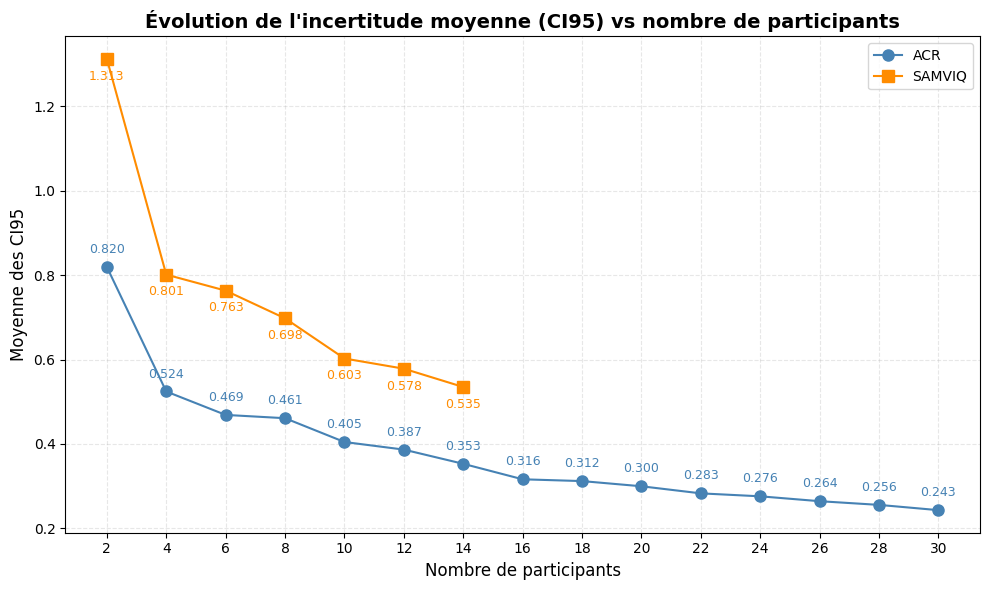

In [149]:
# Plot CI95 moyen en fonction du nombre de participants (filtré vs df complet)
plt.figure(figsize=(10, 6))

# Tracer toutes les valeurs du filtré puis celles du df complet, même si les x diffèrent
participants_filtered = sorted(results_filtered.keys())
participants_full = sorted(results_df.keys())

ci_filtered = [results_filtered[p] for p in participants_filtered]
ci_full = [results_df[p] for p in participants_full]

plt.plot(participants_filtered, ci_filtered, marker='o', markersize=8, color='steelblue', label='ACR')
plt.plot(participants_full, ci_full, marker='s', markersize=8, color='darkorange', label='SAMVIQ')

# Axes et titre
plt.xlabel('Nombre de participants', fontsize=12)
plt.ylabel('Moyenne des CI95', fontsize=12)
plt.title("Évolution de l'incertitude moyenne (CI95) vs nombre de participants", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(sorted(set(participants_filtered) | set(participants_full)))
plt.legend()

# Annotations séparées
for x, y in zip(participants_filtered, ci_filtered):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='steelblue')
for x, y in zip(participants_full, ci_full):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=9, color='darkorange')

plt.tight_layout()
plt.show()

# Opening saved results

In [41]:
df = pd.read_csv(SAVE_PATH + "experimental_results.csv")

In [42]:
df_metrics = pd.read_csv(SAVE_PATH + "df_metrics.csv")

In [43]:
data = pd.read_csv(SAVE_PATH + "df_videos_processed.csv")

In [44]:
metrics_to_analyze = ['SSIM', 'MS_SSIM', 'LPIPS', 'VIFP']